In [1]:
import random
from collections import deque
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter

Compute the single-source dependency scores $δ_s(v)$ for all vertices v in G using the unweighted version of Brandes' algorithm.

In [2]:
def brandes_single_source_dependencies_unweighted(G, s):
    S = []
    P = {v: [] for v in G}
    sigma = dict.fromkeys(G, 0.0)
    dist  = dict.fromkeys(G, -1)

    sigma[s] = 1.0
    dist[s] = 0

    from collections import deque
    Q = deque([s])

    while Q:
        v = Q.popleft()
        S.append(v)
        for w in G[v]:
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                P[w].append(v)

    delta = dict.fromkeys(G, 0.0)
    while S:
        w = S.pop()
        for v in P[w]:
            if sigma[w] != 0:
                delta[v] += (sigma[v] / sigma[w]) * (1 + delta[w])

    return delta

In [3]:
def approx_bc_algorithm1_hybrid(G, c=5.0, cutoff_factor=20, seed=0):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    max_bfs = max(1, n // cutoff_factor)
    print(f"[approx] adaptive + cutoff: max {max_bfs} BFS runs (n/{cutoff_factor}), c={c}")

    S = {v: 0.0 for v in nodes}      
    k = {v: 0   for v in nodes}    
    done = {v: False for v in nodes} 
    remaining = n                 

    bfs_used = 0
    t0 = perf_counter()

    while bfs_used < max_bfs and remaining > 0:
        s = rng.choice(nodes)
        delta = brandes_single_source_dependencies_unweighted(G, s)
        bfs_used += 1

        for v in nodes:
            if done[v] or v == s:
                continue
            S[v] += delta[v]
            k[v] += 1
            if S[v] >= c * n:
                done[v] = True
                remaining -= 1

        if bfs_used % 10 == 0 or bfs_used == max_bfs:
            print(f"[approx] BFS {bfs_used}/{max_bfs}, remaining not-done vertices: {remaining}")

    t1 = perf_counter()
    print(f"[approx] finished in {t1 - t0:.2f}s, BFS_used={bfs_used}")

    bc_hat = {
        v: (n * S[v] / k[v]) if k[v] > 0 else 0.0
        for v in nodes
    }
    return bc_hat, k, bfs_used

In [4]:
def smooth_series(y, window=51):
    w = max(3, int(window))
    if w % 2 == 0:
        w += 1
    if w > len(y):
        w = len(y) if len(y) % 2 == 1 else len(y) - 1
        if w < 3:
            return np.array(y, dtype=float)
    kernel = np.ones(w) / w
    ypad = np.pad(y, (w // 2, w // 2), mode='edge')
    return np.convolve(ypad, kernel, mode='valid')

Random Graph Experiment (Figure 1(a))

Random graph: 2000 7980
[approx] adaptive + cutoff: max 100 BFS runs (n/20), c=5.0
[approx] BFS 10/100, remaining not-done vertices: 2000
[approx] BFS 20/100, remaining not-done vertices: 2000
[approx] BFS 30/100, remaining not-done vertices: 2000
[approx] BFS 40/100, remaining not-done vertices: 2000
[approx] BFS 50/100, remaining not-done vertices: 2000
[approx] BFS 60/100, remaining not-done vertices: 2000
[approx] BFS 70/100, remaining not-done vertices: 2000
[approx] BFS 80/100, remaining not-done vertices: 2000
[approx] BFS 90/100, remaining not-done vertices: 2000
[approx] BFS 100/100, remaining not-done vertices: 2000
[approx] finished in 0.34s, BFS_used=100
[hybrid] BFS used = 100, average samples per node = 99.95


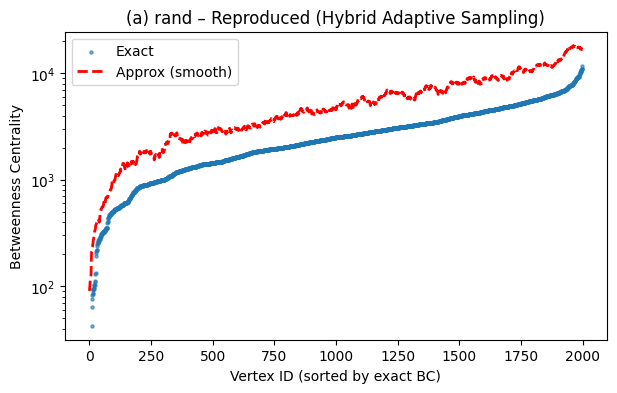

In [5]:
G_rand = nx.gnm_random_graph(n=2000, m=7980, seed=42)

print("Random graph:", G_rand.number_of_nodes(), G_rand.number_of_edges())

# Compute approximate using HYBRID adaptive sampling
approx_rand, k_used, bfs_used = approx_bc_algorithm1_hybrid(
    G_rand, c=5.0, cutoff_factor=20, seed=0
)

print(f"[hybrid] BFS used = {bfs_used}, average samples per node = {np.mean(list(k_used.values())):.2f}")

#Exact Brandes
exact_rand = nx.betweenness_centrality(G_rand, normalized=False)

# Plot
nodes_sorted = sorted(exact_rand.keys(), key=lambda v: exact_rand[v])
x = np.arange(len(nodes_sorted))

y_exact  = np.array([exact_rand[v]  for v in nodes_sorted])
y_approx = np.array([approx_rand[v] for v in nodes_sorted])
y_smooth = smooth_series(y_approx)

plt.figure(figsize=(7,4))
plt.scatter(x, y_exact, s=5, alpha=0.6, label="Exact")
plt.plot(x, y_smooth, "r--", lw=2, label="Approx (smooth)")
plt.yscale("log")
plt.title("(a) rand – Reproduced (Hybrid Adaptive Sampling)")
plt.xlabel("Vertex ID (sorted by exact BC)")
plt.ylabel("Betweenness Centrality")
plt.legend()
plt.show()

In [6]:
def adaptive_sampling_single_vertex(G, target, c=5.0, seed=None):
    """
    Approximate BC(target) using Bader et al. Algorithm 1 (pure adaptive sampling).
    Returns:
        bc_hat : estimated betweenness of target
        k      : number of SSSP/BFS runs (samples)
    """
    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    S = 0.0   # running sum of dependencies on target
    k = 0     # number of samples (BFS runs)

    while S <= c * n:
        s = rng.choice(nodes)
        if s == target:
            continue  # skip self as source
        # one SSSP from s:
        delta = brandes_single_source_dependencies_unweighted(G, s)
        S += delta.get(target, 0.0)
        k += 1

    bc_hat = (n * S / k) if k > 0 else 0.0
    return bc_hat, k

Preproducing Fig. 3 on random graph

k used: 971
k used: 1030
k used: 1042
k used: 888
k used: 976
k used: 907
k used: 1174
k used: 1010
k used: 868
k used: 1151
k used: 1067
k used: 1093
k used: 958
k used: 999
k used: 1126
k used: 954
k used: 786
k used: 1151
k used: 1354
k used: 1042
k used: 1215
k used: 1131
k used: 1186
k used: 935
k used: 1032
k used: 1077
k used: 1106
k used: 1162
k used: 902
k used: 1332
k used: 823
k used: 886
k used: 893
k used: 936
k used: 947
k used: 1150
k used: 1250
k used: 986
k used: 792
k used: 1174
k used: 915
k used: 1340
k used: 1129
k used: 1108
k used: 1083
k used: 1143
k used: 963
k used: 988
k used: 959
k used: 876
k used: 847
k used: 1226
k used: 1133
k used: 857
k used: 1153
k used: 831
k used: 1023
k used: 1273
k used: 1131
k used: 1421
k used: 743
k used: 1002
k used: 972
k used: 921
k used: 1072
k used: 739
k used: 1017
k used: 961
k used: 660
k used: 1059
k used: 845
k used: 1075
k used: 866
k used: 932
k used: 921
k used: 822
k used: 1144
k used: 911
k used: 1244
k used: 814

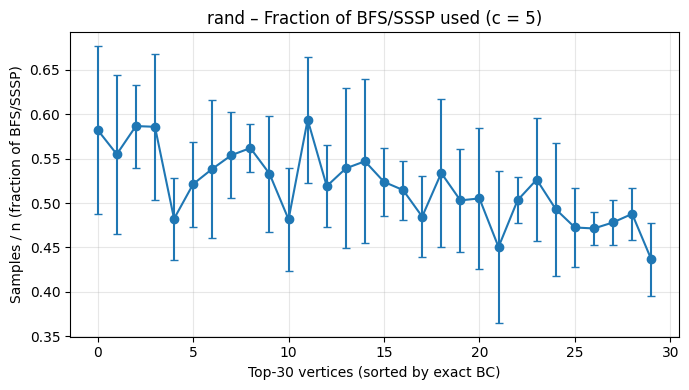

In [7]:
#  exact BC on rand graph 
exact_bc_rand = nx.betweenness_centrality(G_rand, normalized=False)

# top-30 high-centrality vertices
top_k = 30
nodes_desc = sorted(exact_bc_rand.keys(),
                    key=lambda v: exact_bc_rand[v],
                    reverse=True)
top_vertices = nodes_desc[:top_k]

# Adaptive sampling parameters & number of runs
c = 5.0
num_runs = 5
n = G_rand.number_of_nodes()

# Record k/n for each vertex in each run
k_frac_runs = np.zeros((top_k, num_runs), dtype=float)

for r in range(num_runs):
    for i, v in enumerate(top_vertices):
        # For reproducibility, give each (run, vertex) a fixed seed
        seed = 1000 * r + i
        _, k_used = adaptive_sampling_single_vertex(G_rand, v, c=c, seed=seed)
        print("k used:", k_used)
        k_frac_runs[i, r] = k_used / n   # convert to fraction k/n
# Compute mean & std over 5 runs
k_mean = k_frac_runs.mean(axis=1)
k_std  = k_frac_runs.std(axis=1)

# For consistency with the paper: sort by exact BC ascending (left is smallest centrality)
top_vertices_sorted = sorted(top_vertices, key=lambda v: exact_bc_rand[v])
order = [top_vertices.index(v) for v in top_vertices_sorted]
k_mean_sorted = k_mean[order]
k_std_sorted  = k_std[order]

x = np.arange(top_k)

plt.figure(figsize=(7, 4))
plt.errorbar(
    x, k_mean_sorted, yerr=k_std_sorted,
    fmt='o-', capsize=3, linewidth=1.5
)
plt.xlabel("Top-30 vertices (sorted by exact BC)")
plt.ylabel("Samples / n (fraction of BFS/SSSP)")
plt.title("rand – Fraction of BFS/SSSP used (c = 5)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

citation network

In [8]:
def load_cite(path="../data/real-world-old/cite_network_edgelist.txt"):
    G = nx.DiGraph()
    with open(path) as f:
        for line in f:
            parts = line.split()
            if len(parts) >= 2:
                u = int(parts[0])
                v = int(parts[1])
                G.add_edge(u, v)
    print("Cite graph:", G.number_of_nodes(), G.number_of_edges())
    return G

G_cite = load_cite()

Cite graph: 8324 41601


[approx] adaptive + cutoff: max 416 BFS runs (n/20), c=5.0
[approx] BFS 10/416, remaining not-done vertices: 8324
[approx] BFS 20/416, remaining not-done vertices: 8324
[approx] BFS 30/416, remaining not-done vertices: 8324
[approx] BFS 40/416, remaining not-done vertices: 8324
[approx] BFS 50/416, remaining not-done vertices: 8324
[approx] BFS 60/416, remaining not-done vertices: 8324
[approx] BFS 70/416, remaining not-done vertices: 8324
[approx] BFS 80/416, remaining not-done vertices: 8324
[approx] BFS 90/416, remaining not-done vertices: 8324
[approx] BFS 100/416, remaining not-done vertices: 8324
[approx] BFS 110/416, remaining not-done vertices: 8324
[approx] BFS 120/416, remaining not-done vertices: 8324
[approx] BFS 130/416, remaining not-done vertices: 8324
[approx] BFS 140/416, remaining not-done vertices: 8324
[approx] BFS 150/416, remaining not-done vertices: 8324
[approx] BFS 160/416, remaining not-done vertices: 8324
[approx] BFS 170/416, remaining not-done vertices: 832

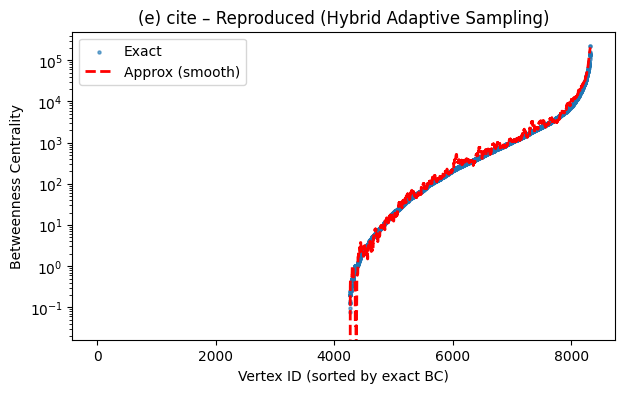

In [9]:
# Approx (Hybrid: adaptive sampling + cutoff n/20)
approx_cite, k_used_cite, bfs_used_cite = approx_bc_algorithm1_hybrid(
    G_cite, c=5.0, cutoff_factor=20, seed=0
)
print(f"[hybrid cite] BFS used = {bfs_used_cite}, "
      f"avg samples per node = {np.mean(list(k_used_cite.values())):.2f}")

# Exact
exact_cite = nx.betweenness_centrality(G_cite, normalized=False)

# Plot
nodes_sorted = sorted(exact_cite.keys(), key=lambda v: exact_cite[v])
x = np.arange(len(nodes_sorted))

y_exact = np.array([exact_cite[v] for v in nodes_sorted])
y_approx = np.array([approx_cite[v] for v in nodes_sorted])
y_smooth = smooth_series(y_approx)

plt.figure(figsize=(7,4))
plt.scatter(x, y_exact, s=5, alpha=0.6, label="Exact")
plt.plot(x, y_smooth, "r--", lw=2, label="Approx (smooth)")
plt.yscale("log")
plt.title("(e) cite – Reproduced (Hybrid Adaptive Sampling)")
plt.xlabel("Vertex ID (sorted by exact BC)")
plt.ylabel("Betweenness Centrality")
plt.legend()
plt.show()

In [10]:
def load_amazon_graph(path, max_nodes=None):


    G = nx.read_edgelist(
        path,
        comments='#',
        delimiter='\t',
        create_using=nx.DiGraph(),
        nodetype=int,
    )
    print(f"[load] full graph: n={G.number_of_nodes()}, m={G.number_of_edges()}")

    # get giant weakly connected component
    if not nx.is_weakly_connected(G):
        gcc_nodes = max(nx.weakly_connected_components(G), key=len)
        G = G.subgraph(gcc_nodes).copy()
        print(f"[load] use giant WCC: n={G.number_of_nodes()}, m={G.number_of_edges()}")

    # optionally restrict to first max_nodes nodes to avoid exact Brandes explosion
    if max_nodes is not None and G.number_of_nodes() > max_nodes:
        # take a subset by node ID (or top-k by degree)
        keep = list(sorted(G.nodes()))[:max_nodes]
        G = G.subgraph(keep).copy()
        print(f"[load] restricted to first {max_nodes} nodes: n={G.number_of_nodes()}, m={G.number_of_edges()}")

    return G

In [11]:
# Load Amazon graph
amazon_path = "../data/real-world-new/Amazon0302_directed.txt"

G_amz = load_amazon_graph(amazon_path)

print("Amazon subgraph:", G_amz.number_of_nodes(), G_amz.number_of_edges())

# Approximate: Hybrid Adaptive Sampling
approx_amz, k_used_amz, bfs_used_amz = approx_bc_algorithm1_hybrid(
    G_amz,
    c=5.0,
    cutoff_factor=20,
    seed=0,
)

print(f"[hybrid Amazon] BFS used = {bfs_used_amz}, "
      f"average samples per node = {np.mean(list(k_used_amz.values())):.2f}")

# Exact Brandes (note: this step is O(nm), run only on the subgraph)
t0 = perf_counter()
exact_amz = nx.betweenness_centrality(G_amz, normalized=False)
t1 = perf_counter()
print(f"[exact Amazon] finished in {t1 - t0:.2f}s")

# ---- Plot Figure 1 style distribution ----
nodes_sorted = sorted(exact_amz.keys(), key=lambda v: exact_amz[v])
x = np.arange(len(nodes_sorted))

y_exact  = np.array([exact_amz[v]       for v in nodes_sorted])
y_approx = np.array([approx_amz[v]      for v in nodes_sorted])
y_smooth = smooth_series(y_approx, window=max(31, len(y_approx)//50))

plt.figure(figsize=(7, 4))
plt.scatter(x, y_exact, s=5, alpha=0.6, label="Exact")
plt.plot(x, y_smooth, "r--", lw=2, label="Approx (smooth)")
plt.yscale("log")
plt.title("(Amazon0302) Betweenness Distribution – Hybrid Adaptive Sampling")
plt.xlabel("Vertex ID (sorted by exact BC)")
plt.ylabel("Betweenness Centrality")
plt.legend()
plt.tight_layout()
plt.show()

[load] full graph: n=262111, m=1234877
Amazon subgraph: 262111 1234877
[approx] adaptive + cutoff: max 13105 BFS runs (n/20), c=5.0
[approx] BFS 10/13105, remaining not-done vertices: 262111
[approx] BFS 20/13105, remaining not-done vertices: 262111
[approx] BFS 30/13105, remaining not-done vertices: 262111
[approx] BFS 40/13105, remaining not-done vertices: 262111
[approx] BFS 50/13105, remaining not-done vertices: 262111
[approx] BFS 60/13105, remaining not-done vertices: 262111
[approx] BFS 70/13105, remaining not-done vertices: 262111
[approx] BFS 80/13105, remaining not-done vertices: 262111
[approx] BFS 90/13105, remaining not-done vertices: 262111
[approx] BFS 100/13105, remaining not-done vertices: 262111
[approx] BFS 110/13105, remaining not-done vertices: 262111
[approx] BFS 120/13105, remaining not-done vertices: 262111
[approx] BFS 130/13105, remaining not-done vertices: 262111
[approx] BFS 140/13105, remaining not-done vertices: 262110
[approx] BFS 150/13105, remaining not

KeyboardInterrupt: 